# 决策树与随机森林

In [1]:
import numpy as np
import pandas as pd
import collections
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_score,recall_score,confusion_matrix
import time

In [2]:
train_data = pd.read_excel("data/BankChurners2.xlsx",sheet_name=0)
test_data = pd.read_excel("data/BankChurners2.xlsx",sheet_name=1)
train_data.head()

,id,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1,Existing Customer,46,M,2,Uneducated,Single,$60K - $80K,Blue,35,...,1,1,5131.0,1484,3647.0,0.750,7432,92,0.559,0.289
1,2,Existing Customer,58,M,3,Graduate,Married,$120K +,Blue,52,...,2,5,17934.0,1578,16356.0,0.593,2005,48,0.778,0.088
2,3,Existing Customer,47,M,3,Graduate,Unknown,$60K - $80K,Blue,36,...,3,2,21142.0,0,21142.0,0.812,4360,66,1.357,0.000
3,4,Attrited Customer,54,M,2,Graduate,Single,$80K - $120K,Blue,36,...,3,3,12342.0,0,12342.0,0.431,1430,37,0.423,0.000
4,5,Existing Customer,44,F,3,Uneducated,Single,Less than $40K,Blue,38,...,1,3,1438.3,0,1438.3,0.801,4287,80,0.667,0.000


## 决策树

In [3]:
class Node:
    """
    class Node(self)
    |  决策树的每一个节点
    |  提供记录节点信息，定位子节点和父节点，存储label等功能
    |
    |  Atrribute
    |  ----------
    |  __init__(self) : None
    |      初始化函数
    |  setLabel(self, label : str) -> None
    |      设置节点的label标签
    |  add_child_info(self, character : str, label, value) -> None
    |      通过传入信息来添加一个子节点
    |  add_child_node(self, node, value) -> None
    |      通过传入节点来直接添加子节点
    |  getLabel(self) -> None
    |      获得该节点的label
    |  setParent(self, node : 'Node') -> None
    |      设置该节点所连接的父节点，在剪枝时需要
    """
    def __init__(self,method : str='ID3') -> None:
        if method == 'ID3' or method == 'C4.5':
            self.character = None # 储节点类型，存取值['root','child node','leaf']
            self.children = {} # 存储子节点的字典，字典的key是连接子节点的edge
            self._parent = None # 所连接的父节点
            self._label = None # 节点的标签
            self.Nt = 0 # 该节点下包含的样本量
            self.Ntk = None # 该节点下目标标签的分布，是一个pd.Series
            self.entropy = 0 # 该节点下的经验熵
            self.depth = None # 该节点所处的树深度
            self.maxLabel = None # 该节点下数量最多的目标标签
        if method == 'CART':
            self.character = None # 储节点类型，存取值['root','child node','leaf']
            self.split = None # 划分节点
            self.LEFT = None # 左节点
            self.RIGHT = None # 右节点
            self._parent = None # 所连接的父节点
            self._label = None # 节点的标签
            self.Nt = 0 # 该节点下包含的样本量
            self.Ntk = None # 该节点下目标标签的分布，是一个pd.Series
            self.depth = None # 该节点所处的树深度
            self.loss = None # 该节点的损失函数值
            self.Gini = None # 该节点的Gini指数
            self.kind = None # 该节点是类别型还是数值型
            self.alpha = None # 决定是否剪枝的临界值

    def setLabel(self, label : str) -> None:
        """
        setLabel(self, label : str) -> None
            设置节点的label标签
        
        Parameters
        ----------
        label : str
            将该节点的标签设置为label
        """
        self._label = label
    
    def add_child_info(self, character : str, label : str, value) -> None:
        """
        add_child_info(self, character : str, label, value) -> None
            通过传入信息来添加一个子节点
        
        Parameters
        ----------
        character : str
            子节点的类型，取值['child node','leaf']
        label : str
            子节点的的标签
        value : str, int 或 float
            这是父节点与子节点的连接索引\n
            父节点通过self.children[value]来定位到该子节点
        """
        node = Node()
        node.character = character
        node.setLabel(label)
        self.children[value] = node
    
    def add_child_node(self, node : 'Node', value) -> None:
        """
        add_child_node(self, node, value) -> None
            通过传入节点来直接添加子节点
        
        Parameters
        ----------
        node : Node
            待添加的子节点子节点
        value : str, int 或 float
            这是父节点与子节点的连接索引\n
            父节点通过self.children[value]来定位到该子节点
        """
        self.children[value] = node
    
    def getLabel(self) -> None:
        """
        getLabel(self) -> None
            设置节点的label标签
        
        Return
        ----------
        self._label : str
            返回该节点的标签
        """
        return self._label
    
    def setParent(self, node : 'Node') -> None:
        """
        setParent(self, node : 'Node') -> None
            设置该节点所连接的父节点，在剪枝时需要
        
        Parameters
        ----------
        node : Node
            将该节点连接到它的父节点node
        """
        self._parent = node

In [4]:
class DecisionTree:
    """
    class DecisionTree(task,method):
    |  决策树模型
    |  利用Node节点生成决策模型，可以指定任务类型是分类或回归，并指定随机数的生成算法
    |
    |  Parameters
    |  ----------
    |  task : str, optional
    |      决策树的任务，取值['regression','classification']\n
    |      默认值'classification'
    |  method : str, optional
    |      指定决策树的生成算法
    |      当决策树的任务是分类时，默认采用ID3算法，可以指定为C4.5算法
    |      当决策树的任务是回归时，采用CART算法
    |
    |  Atrribute
    |  ----------
    |  __init__(self, task : str='classification', method : str='ID3') -> None
    |      初始化函数
    |  fit(self, X, y, is_pruning : bool=True, alpha : float=0.01)
    |      训练函数
    |  predict(self, X : pd.DataFrame)
    |      预测函数
    |  accuracy(self, X : pd.DataFrame, y_true : pd.Series) -> float
    |      正确率计算函数
    |  _TreeGenerator(self, Data : tuple, Attribute : list, deep : int)
    |      ID3，C4.5树生成函数
    |  _TreeGeneratorCART(self, Data : tuple, Attribute : list, deep : int)
    |      CART树生成函数
    |  _Pruning(self, alpha : float=0.01) -> None
    |      ID3, C4.5剪枝函数
    |  _PruningCART(self, valid_data : tuple) -> None
    |      CART剪枝函数
    """
    def __init__(self, task : str='classification', method : str='ID3') -> None:
        """
        __init__(self, task : str='classification', method : str='ID3') -> None
            初始化函数，设置任务类型和决策树使用的算法
        
        Parameters
        ----------
        task : str, optional
            决策树的任务类型，取值['regression','classification']\n
            默认值'classification'
        method : str, optional
            决策树生成所使用的算法\n
            当决策树的任务是分类时，默认采用ID3算法，可以指定为C4.5算法\n
            当决策树的任务是回归时，采用CART算法\n
        """
        self.gain = {} # 信息增益
        self.task = task
        self.method = method
        self._columns = None
        self._columns_index = {}
        # 决策树
        self.tree = None
        self.Attribute_values = {}
        self.leaf_ptr = {}
        self.num_leaf = 0
        self.treeEntropy = 0
        self.N = 0
        self.numerical_cols = []
        self.category_cols = []
        self.alphaTree = {}
        self.pruningTree = {}
        
    def fit(self, X : pd.DataFrame, y : pd.Series, numerical_cols : list, 
            is_pruning : bool=True, alpha : float=1e-4, valid_data : tuple=None, max_feature_split : int=None, **kwargs) -> None:
        """
        fit(self, X, y, is_pruning : bool=True, alpha : float=0.01) -> None
            输入训练数据集，训练函数，生成决策树
        
        Parameters
        ----------
        X : pd.DataFrame
            数据的特征
        y : pd.Series
            数据的标签
        is_pruning : bool, optional
            是否对训练好的模型进行剪枝，默认值True
        valid_data : tuple
            对CART决策树剪枝时所需的验证数据集，它应该和训练数据集独立\n
            valid_data的形式为(X_valid,y_valid)的元组\n
        alpha : float, optional
            剪枝算法中的正则化系数，默认值1e-4\n
            alpha取值越大，模型复杂度越低
        valid_data : tuple
            CART决策树在剪枝过程中的验证数据集\n
            valid_data应该具有(X_valid,y_valid)的形式\n
        max_feature_split : int, optional
            决策树分裂时所考虑的最大分裂特征数量\n
            默认值为None，表示不限制特征数量，使用所有特征
        """
        # 保存信息
        self._columns = list(X.columns)
        self.numerical_cols = numerical_cols
        self.category_cols = list(set(self._columns) - set(self.numerical_cols))
        self.N = X.shape[0]
        # 计算信息增量
        if self.method == 'ID3' or self.method == 'C4.5':
            for i,col in enumerate(self._columns):
                self.gain[col] = self.__mutaul_information(X[col],y)
                self.Attribute_values[col] = X[col].unique()
                self._columns_index[col] = i
            self.gain = pd.Series(self.gain)
            self.tree = self._TreeGenerator((X,y), self._columns,deep=1)
            self.tree.character = 'root node'
            self.leaf_ptr = pd.Series(self.leaf_ptr)
            self.num_leaf = sum([len(l) for l in self.leaf_ptr])
        if self.method == 'CART':
            for i,col in enumerate(self._columns):
                self._columns_index[col] = i
            if max_feature_split:
                cols_use = pd.Series(self._columns)
                cols_use = list(cols_use.sample(n=max_feature_split).values)
            else:
                cols_use = self._columns.copy()
            self.tree = self._TreeGeneratorCART((X,y), cols_use, deep=1, **kwargs)
            self.tree.character = 'root node'
            self.leaf_ptr = pd.Series(self.leaf_ptr)
            self.num_leaf = sum([len(l) for l in self.leaf_ptr])
        # 剪枝
        if is_pruning:
            if self.method == 'CART':
                if not valid_data:
                    raise "没有提供验证数据集!"
                self._PruningCART(valid_data=valid_data)
            else:
                self._Pruning(alpha)
        

    def predict(self, X : pd.DataFrame) -> pd.Series:
        """
        predict(self, X : pd.DataFrame) -> pd.Series
            输入数据，进行预测
        
        Parameters
        ----------
        X : pd.DataFrame
            数据的特征

        Return
        ----------
        y_pred : pd.Series
            模型在输入X上的预测
        """
        y_pred = []
        for x in X.values:
            tree = self.tree
            if self.method == 'ID3' or self.method == 'C4.5':
                while tree.character != 'leaf':
                    tree = tree.children[x[self._columns_index[tree.getLabel()]]]
                y_pred.append(tree.getLabel())
            if self.method == 'CART':
                # try:
                while tree.character != 'leaf':
                        if tree.kind == 'category':
                            if x[self._columns_index[tree.getLabel()]] == tree.split:
                                tree = tree.LEFT
                            else:
                                tree = tree.RIGHT
                        if tree.kind == 'numerical':
                            if x[self._columns_index[tree.getLabel()]] <= tree.split:
                                tree = tree.LEFT
                            else:
                                tree = tree.RIGHT
                y_pred.append(tree.getLabel())
                # except:
                #     y_pred.append(tree.getLabel())
        return pd.Series(y_pred)

    def accuracy(self, X : pd.DataFrame, y_true : pd.Series, eval : str='mean square error') -> float:
        """
        accuracy(self, X : pd.DataFrame, y_true : pd.Series) -> float
            输入数据，进行预测
        
        Parameters
        ----------
        X : pd.DataFrame
            数据的特征
        y_true : pd.Series
            给定输入X的真实标签
        eval : str, optional
            回归问题的评估指标，可选['MSE','MAE']
            默认值'MSE'
        
        Return
        ----------
        acc : float
            模型在输入X上预测的准确率
        """
        y_pred = self.predict(X)
        if self.task == 'classification':
            return (y_pred == y_true).sum() / len(y_true)
        if self.task == 'regression':
            if eval in ['mean square error','MSE']:
                return ((y_pred - y_true)**2).mean()
            if eval in ['maximum absolute error','MAE']:
                return max(abs(y_pred - y_true))
            if eval in ['mean absolute error']:
                return (abs(y_pred - y_true)).mean()

    def _TreeGenerator(self, Data : tuple, Attribute : list, deep : int) -> None:
        """
        _TreeGenerator(self, Data : tuple, Attribute : list, deep : int) -> None
            决策树生成函数
        
        Parameters
        ----------
        Data : tuple
            包含特征和标签的元组(X,y)
        Attribute : list
            特征集合
        deep : int
            当前递归时树的深度
        """
        # 创建节点，统计该节点下样本分配情况
        node = Node()
        node.Nt = len(Data[1])
        node.Ntk = Data[1].value_counts()
        # 统计数量最多的标签
        node.maxLabel = Data[1].value_counts().index[0]
        # 记录当前树的递归深度
        node.depth = deep
        # 计算该节点处的熵
        if node.Nt > 0:
            node.entropy = self.__empiricalEntropy(node.Ntk)
        # 若样本全部属于同一类别
        if Data[1].nunique() == 1:
            node.character = 'leaf'
            node.setLabel(Data[1].values[0])
            # 保存叶节点的指针，用于剪枝
            if deep in self.leaf_ptr:
                self.leaf_ptr[deep].append(node) 
            else:
                self.leaf_ptr[deep] = [node]
            return node
        # 如果A为空集，或者样本在A上的取值完全相同
        if len(Attribute) == 0 or max(Data[0][Attribute].nunique()) == 1:
            node.character = 'leaf'
            node.setLabel((Data[1].value_counts()).index[0])
            # 保存叶节点的指针，用于剪枝
            if deep in self.leaf_ptr:
                self.leaf_ptr[deep].append(node)
            else:
                self.leaf_ptr[deep] = [node]
            return node
        # 筛选信息增量最大的属性
        Attribute_max = self.gain[Attribute].index[self.gain[Attribute].argmax()]
        node.setLabel(Attribute_max)
        node.character = 'child node'
        for value in self.Attribute_values[Attribute_max]:
            index = Data[0][Attribute_max]==value
            if index.sum() == 0:
                node.add_child_info(character='leaf',label=(Data[1].value_counts()).index[0],value=value)
                # 添加父节点关系，更新树深度
                node.children[value].setParent(node)
                node.children[value].depth = deep + 1
            else:
                # 更新样本集和标签集，准备递归
                Dx = Data[0][index]
                Dy = Data[1][index]
                Dv = (Dx,Dy)
                Attribute_v = Attribute.copy()
                Attribute_v.remove(Attribute_max)
                # 递归添加叶节点，注意更新深度
                node.add_child_node(self._TreeGenerator(Dv,Attribute_v,deep=deep + 1),value=value)
                # 添加父节点关系
                node.children[value].setParent(node)
        return node
    
    def _TreeGeneratorCART(self, Data : tuple, Attribute : list, deep : int, \
                           sample_threshold : int=10, loss_threshold : float=5, max_depth : int=None) -> None:
        """
        _TreeGeneratorCART(self, Data : tuple, Attribute : list, deep : int) -> None
            使用CART算法生成决策树
        
        Parameters
        ----------
        Data : tuple
            包含特征和标签的元组(X,y)
        Attribute : list
            特征集合
        deep : int
            当前递归时树的深度
        sample_threshold : int, optional
            样本个数阈值，当划分后样本量小于该阈值\n
            则停止划分，并取均值作为预测值，默认值5\n
        loss_threshold : float, optional
            评估指标的临界值，如果是分类任务，则代表Gini指标，如果是回归任务，则代表误差平方和\n
            当划分下所有样本的评价指标小于该阈值时，停止划分\n
            默认值1\n
        """
        # 创建节点，统计该节点下样本分配情况
        node = Node('CART')
        node.Nt = len(Data[1])
        node.Ntk = Data[1].value_counts()
        # 记录当前树的递归深度
        node.depth = deep
        # 计算该节点处的最优预测及均方损失
        if node.Nt > 0:
            # 计算均值作为该节点下得最优预测
            if self.task == 'regression':
                node.maxLabel = Data[1].mean()
                node.loss = self.__MSEloss(Data[1],node.maxLabel)
            # 以当前类别最多的类得到最优预测
            else:
                node.maxLabel = (Data[1].value_counts()).index[0]
                node.loss = self.__Gini(Data[1])
        # 样本量个数小于阈值 OR 如果没有更多特征，即A为空集 OR 如果均方误差小于临界值
        if (node.Nt <= sample_threshold) or (len(Attribute) == 0) or (node.loss < loss_threshold)\
            or (max_depth and deep > max_depth):
            node.character = 'leaf'
            node.setLabel(node.maxLabel)
            # 保存叶节点的指针，用于剪枝
            if deep in self.leaf_ptr:
                self.leaf_ptr[deep].append(node) 
            else:
                self.leaf_ptr[deep] = [node]
            return node
        # 计算切分点(s,j)
        min_split_feature = None # 待确认的划分特征s
        min_split_point = None # 待确认的划分点j
        min_score = np.inf # 用于更新最小平方误差和
        for A in Attribute: # 遍历每一个特征s
            # 如果该特征是类别型变量
            min_store = {} # 存储当前特征各分割点的分数
            if A in self.category_cols: 
                values = Data[0][A].unique()
            else:
                # 求出分割点
                if node.Nt > 10: # 样本量较大时，用分位数求
                    values = [Data[0][A].quantile(0.1*i) for i in range(1,10)]
                else:
                    temp = (Data[0][A].sort_values()).values # 样本量较小时，直接求间隔值
                    values = [(temp[i]+temp[i+1])/2 for i in range(len(temp)-1)]
            # 遍历每一个可能取值，计算平方损失和
            # 便利每一种可能的二叉划分，计算平方损失和
            for split_point in values:
                if A in self.category_cols: 
                    index_true = Data[0][A] == split_point
                    index_false = Data[0][A] != split_point
                else:
                    index_true = Data[0][A] <= split_point
                    index_false = Data[0][A] > split_point
                # 计算平方误差和或者Gini指标
                min_store[split_point] = 0
                if self.task == 'regression':
                    if index_true.any():
                        min_store[split_point] += self.__MSEloss(Data[1].values[index_true],Data[1].values[index_true].mean())
                    if index_false.any():
                        min_store[split_point] += self.__MSEloss(Data[1].values[index_false],Data[1].values[index_false].mean())
                else:
                    if index_true.any():
                        min_store[split_point] += (index_true.sum()/node.Nt)*self.__Gini(Data[1][index_true])
                    if index_false.any():
                        min_store[split_point] += (index_false.sum()/node.Nt)*self.__Gini(Data[1][index_false])
            # 在损失中找到最小的分裂点j
            min_store = pd.Series(min_store)
            min_store = min_store.sort_values()
            # 如果找到了损失更小的划分，则更新划分点
            if min_store.values[0] < min_score:
                min_score = min_store.values[0]
                min_split_feature = A
                min_split_point = min_store.index[0]
        # 记录该节点的分割位置
        node.split = min_split_point
        node.setLabel(min_split_feature) # 为该店添加特征标签
        node.character = 'child node' # 标记该点的类型
        node.kind = 'category' if min_split_feature in self.category_cols else 'numerical' # 标记该节点的划分变量类型
        # 确定数据集划分的索引
        if node.kind == 'category':
            index_left = Data[0][min_split_feature] == min_split_point
            index_right = Data[0][min_split_feature] != min_split_point
        else:
            index_left = Data[0][min_split_feature] <= min_split_point
            index_right = Data[0][min_split_feature] > min_split_point
        # 利用索引划分数据集
        Dx_left = Data[0][index_left]
        Dx_right = Data[0][index_right]
        Dy_left = Data[1][index_left]
        Dy_right = Data[1][index_right]
        # 递归添加叶节点，注意更新深度
        if node.kind == 'category':
            # 判断是否需要剔除一些不再需要划分的列
            Attribute_left, Attribute_right = Attribute.copy(), Attribute.copy()
            Attribute_left.remove(min_split_feature)
            if Dx_right[min_split_feature].nunique() == 1:
                Attribute_right.remove(min_split_feature)
            node.LEFT = self._TreeGeneratorCART((Dx_left,Dy_left), Attribute_left,\
                                                 deep + 1, sample_threshold, loss_threshold, max_depth)
            node.RIGHT = self._TreeGeneratorCART((Dx_right,Dy_right), Attribute_right,\
                                                  deep + 1, sample_threshold, loss_threshold, max_depth)
        else:
            node.LEFT = self._TreeGeneratorCART((Dx_left,Dy_left), Attribute,\
                                                 deep + 1, sample_threshold, loss_threshold, max_depth)
            node.RIGHT = self._TreeGeneratorCART((Dx_right,Dy_right), Attribute,\
                                                  deep + 1, sample_threshold, loss_threshold, max_depth)
        # 添加父节点信息
        node.LEFT.setParent(node)
        node.RIGHT.setParent(node)
        return node

    # 剪枝
    def _Pruning(self, alpha : float=1e-4) -> None:
        """
        _Pruning(self, alpha : float=0.01) -> None
            对生成好的决策树进行剪枝
        
        Parameters
        ----------
        alpha : float, optional
            剪枝时的正则化系数，默认值1e-4\n
            alpha取值越大，模型复杂度越低
        """
        # 计算整棵树的完整熵
        for key in self.leaf_ptr.index: # 按深度遍历叶节点
            for leaf in self.leaf_ptr[key]: # 遍历所有叶节点的指针
                self.treeEntropy += leaf.Nt*leaf.entropy / self.N
        self.treeEntropy += alpha*sum([len(leaf) for leaf in self.leaf_ptr]) # 添加上模型复杂度
        # 开始循环剪枝，直至子树的熵不再减少
        flag = 1 # 判别变量
        while flag:
            flag = 0
            self.leaf_ptr = self.leaf_ptr.sort_index(ascending=False) # 按叶节点深度排序
            for depth in self.leaf_ptr.index: # 按深度遍历叶节点
                for leaf in self.leaf_ptr[depth]: # 遍历所有叶节点的指针
                    newEntropy = self.__newEntropy(leaf,alpha) # 计算叶节点回缩到父节点后新树的熵
                    if newEntropy > self.treeEntropy:
                        continue
                    # 进入到剪枝分支
                    else:
                        flag = 1 # 改变判别变量，再次循环
                        # 创建双边队列，准别遍历树结构删除该父节点下的所有叶
                        queue = collections.deque([leaf._parent]) 
                        while len(queue) > 0:
                            child = queue.popleft()
                            # 删除叶子并删除叶的指针
                            if child.character == 'leaf' and child in self.leaf_ptr[child.depth]:
                                self.leaf_ptr[child.depth].remove(child)
                                self.num_leaf -= 1 # 更新叶节点数量
                            else:
                                for c,c_node in child.children.items(): # 广度优先，添加其它叶子
                                    queue.append(c_node)
                        # 更新父节点的子节点信息
                        leaf._parent.children = {}
                        # 将父节点设置为叶节点
                        leaf._parent.character = 'leaf'
                        leaf._parent.setLabel(leaf._parent.maxLabel)
                        # 更新叶节点数量
                        self.num_leaf += 1
                        # 将新的叶节点的指针保存
                        if depth-1 in self.leaf_ptr.index:
                            self.leaf_ptr[depth-1].append(leaf._parent)
                        else:
                            self.leaf_ptr[depth-1] = [leaf._parent]
                        # 更新树的熵
                        del leaf
                        self.treeEntropy = newEntropy
                        break # 每次更新跳出当前循环，从头开始剪枝
                # 如果判别指标为真，直接跳出深度遍历，从头开始遍历整个树的叶
                if flag == 1:
                    break
    
    # CART剪枝
    def _PruningCART(self, valid_data : tuple=None, greater_is_better : bool=True) -> None:
        """
        _PruningCART(self) -> None
            对生成好的CART决策树进行剪枝
        
        Parameters
        ----------
        valid_data : tuple
            剪枝时所需的验证数据集，它应该和训练数据集独立\n
            valid_data的形式为(X_valid,y_valid)的元组\n
        greater_is_better : bool, optional
            在进行交叉验证选择最优子树时，确定决策分数是越高越好(例如正确率)还是越低越好(例如平方误差)\n
            默认值为True
        """
        # 计算以每个子节点为根节点剪枝临界值alpha
        # 广度有限搜索
        queue = collections.deque([self.tree])
        while len(queue) > 0:
            child = queue.popleft()
            # 如果不是叶节点，就计算剪枝临界值
            if child.character != 'leaf':
                self.__computeAlpha(child)
                # 为该临界值添加指向该根节点的指针
                self.alphaTree[child.alpha] = child
                if child.LEFT.character != 'leaf':
                    queue.append(child.LEFT)
                if child.RIGHT.character != 'leaf':
                    queue.append(child.RIGHT)
        self.alphaTree = pd.Series(self.alphaTree)
        # 排序
        self.alphaTree = self.alphaTree.sort_index(ascending=True)
        # 保存原始的完整树
        self.pruningTree[0] = self.__copyTreeCART(self.tree)
        # # 开始剪枝
        for alpha in self.alphaTree.index:
            # 剪掉alpha对应的节点
            node = self.alphaTree[alpha]
            # 节点回退
            node.LEFT = None
            node.RIGHT = None
            # 将父节点设置为叶节点
            node.character = 'leaf'
            node.setLabel(node.maxLabel)
            # 复制这棵树
            self.pruningTree[alpha] = self.__copyTreeCART(self.tree)
        if greater_is_better:
            best_score = -np.inf
        else:
            best_score = np.inf
        # 选择最好的树
        for alpha,tree in self.pruningTree.items():
            self.tree = tree
            score = self.accuracy(valid_data[0],valid_data[1])
            if greater_is_better:
                if score > best_score:
                    best_score = score
                    best_alpha = alpha
            else:
                if score < best_score:
                    best_score = score
                    best_alpha = alpha
        # 保存最好的树
        self.tree = self.pruningTree[best_alpha]
                    
    def __entropy(self, X : pd.Series) -> float:
        """
        信息熵计算函数
        """
        p = X.value_counts() / len(X)
        return -(p*np.log2(p)).sum()

    def __relative_entropy(self, X : pd.Series, Y : pd.Series) -> float:
        """
        相对熵计算函数
        """
        H = 0
        for x in X.unique():
            nx = (X==x).sum()
            h = 0
            for y in Y.unique():
                if ((X==x) & (Y==y)).any():
                    h += ((X==x) & (Y==y)).sum() / nx
                else:
                    h += 0
            H += -h * nx / len(X)
        return H

    def __mutaul_information(self, X : pd.Series, Y : pd.Series) -> float:
        """
        互信息量计算函数
        """
        return self.__entropy(X) - self.__relative_entropy(X,Y)
    
    def __empiricalEntropy(self, Ntk : pd.Series) -> float:
        """
        各叶子节点的经验熵计算函数
        """
        p = Ntk / Ntk.sum()
        return -(p*np.log(p)).sum()
    
    def __MSEloss(self, y : pd.Series, label : float) -> float:
        """
        计算均方损失
        """
        return ((y - label)**2).sum()
    
    def __Gini(self, y : pd.Series) -> float:
        """
        计算Gini指数
        """
        p = y.value_counts() / len(y)
        return 1 - (p**2).sum()
    
    def __newEntropy(self, node : 'Node', alpha : float) -> float:
        """
        __newEntropy(self, node : 'Node', alpha : float) -> float
            剪枝时，计算叶节点回缩到父节点后，新树的熵
        
        Parameters
        ----------
        node : Node
            要进行剪切的叶节点
        alpha : float
            剪枝算法的正则化参数
        
        Return
        ----------
        entropy : float
            叶节点回缩到父节点后，新树的熵
        """
        entropy = self.treeEntropy # 在原有熵的基础上更新
        try:
            # 创建双边队列，使用广度优先寻找每一个叶节点
            queue = collections.deque([node._parent])
            while len(queue) > 0:
                child = queue.popleft()
                # 减去该叶节点，熵的变化量
                if child.character == 'leaf':
                    entropy -= (child.Nt*child.entropy/self.N+alpha)
                else:
                    for c,c_node in child.children.items(): # 添加其它叶节点
                        queue.append(c_node)
            # 所有叶节点删除后，添加上最新父节点的熵和对应的复杂度
            entropy += node._parent.Nt*node._parent.entropy/self.N
            entropy += alpha
            return entropy
        except AttributeError:
            return entropy + 1
    
    # 计算CART决策树的剪枝临界值
    def __computeAlpha(self, node : 'Node') -> None:
        """
        __computeAlpha(self, node : 'Node') -> None
            CART剪枝时，计算各子节点的剪枝临界值alpha，并保存到各个节点
        
        Parameters
        ----------
        node : Node
            决策树中的子节点
        """
        # 该node为根下的叶节点数量
        T = 0
        # 该node为根下的叶节点带来的损失
        root_loss = 0
        # 创建双边队列，使用广度优先搜索寻找每一个叶节点
        queue = collections.deque([node])
        while len(queue) > 0:
            child = queue.popleft()
            # 如果是叶节点，计算以node为根节点的树的损失
            if child.character == 'leaf':
                root_loss += (child.Nt/self.N)*child.loss
                T += 1
            # 添加节点
            else:
                if child.LEFT:
                    queue.append(child.LEFT)
                if child.RIGHT:
                    queue.append(child.RIGHT)
        # 记录下alpha的值
        node.alpha = (node.loss*node.Nt/self.N - root_loss) / (T - 1)
    
    # 复制一棵树
    def __copyTreeCART(self, node : 'Node') -> 'Node':
        """
        __copyTreeCART(self, node : 'Node') -> 'Node'
            CART剪枝时，对各个剪枝后的子树进行拷贝复制
        
        Parameters
        ----------
        node : Node
            CART剪枝过程中子树的头节点
        """
        # 创建新节点，复制节点信息
        copy_node = Node('CART')
        copy_node.character = node.character # 该节点的属性
        copy_node.split = node.split # 该节点的最佳分裂点
        copy_node._label = node._label # 该节点的标签
        copy_node.Nt = node.Nt # 该节点所包含的样本量
        copy_node.depth = node.depth # 该节点所处的树深度
        copy_node.loss = node.loss # 该节点的平方损失和
        copy_node.Gini = node.Gini # 该节点的Gini指数
        copy_node.kind = node.kind # 该节点是类别型还是数值型
        copy_node.alpha = node.alpha # 决定是否剪枝的临界值
        # 如果没有复制到叶节点，则递归地复制左右节点
        if copy_node.character != 'leaf':
            copy_node.LEFT = self.__copyTreeCART(node.LEFT)
            copy_node.RIGHT = self.__copyTreeCART(node.RIGHT)
            # 设置节点的父亲
            copy_node.LEFT.setParent(copy_node)
            copy_node.RIGHT.setParent(copy_node)
        return copy_node

In [5]:
def evaluate(model,task : str='regression'):
    if task == 'regression':
        print("train: ")
        print("mean square error: ",model.accuracy(train_data[features],train_data[label],'MSE'))
        print("maximum absolute error: ",model.accuracy(train_data[features],train_data[label],'MAE'))
        print("mean absolute error: ",model.accuracy(train_data[features],train_data[label],'mean absolute error'))
        print("test: ")
        print("mean square error: ",model.accuracy(test_data[features],test_data[label],'MSE'))
        print("maximum absolute error: ",model.accuracy(test_data[features],test_data[label],'MAE'))
        print("mean absolute error: ",model.accuracy(test_data[features],test_data[label],'mean absolute error'))
    if task == 'classification':
        print("train: ")
        print("acc: ",model.accuracy(train_data[features],train_data[label]))
        print("test: ")
        print("acc: ",model.accuracy(test_data[features],test_data[label]))

## 随机森林

In [7]:
class RandomForest(DecisionTree):
    """
    class RandomForest(DecisionTree):
    |  随机森林模型
    |  继承自决策树，通过调用多棵决策树，使用投票或平均的方法实现分类和回归
    |
    |  Parameters
    |  ----------
    |  task : str, optional
    |      任务类型，取值['regression','classification']\n
    |      默认值'classification'
    |  n_estimators : int, optional
    |      所使用的分类器个数，默认值10
    |  max_feature_split : int, optional
    |      训练单棵决策树时的最大分类特征数量
    |      默认值None，表示使用所有特征
    |  max_depth : int, optional
    |      训练单棵决策树时的最大树深度
    |      默认值None，表示不限制树的深度
    |  min_sample_leaf : int, optional
    |      训练单棵决策树时的叶子节点的最小样本数量
    |      默认值1
    |
    |  Atrribute
    |  ----------
    |  __init__(self, task : str='classification', n_estimators : int=10, 
    |           max_feature_split : int=None, max_depth : int=None, min_sample_leaf : int=1) -> None
    |      初始化函数
    |  fit(self, X : pd.DataFrame, y : pd.Series, numerical_cols : list=None) -> None
    |      训练函数
    |  predict(self, X : pd.DataFrame)
    |      预测函数
    |  accuracy(self, X : pd.DataFrame, y_true : pd.Series) -> float
    |      正确率计算函数
    |  
    |  以及其它从父类DecisionTree继承得到的方法
    |
    """
    def __init__(self, task : str='classification', n_estimators : int=10, 
                max_feature_split : int=None, max_depth : int=None, min_sample_leaf : int=1) -> None:
        """
        __init__(self, task : str='classification', n_estimators : int=10, 
                max_feature_split : int=None, max_depth : int=None, min_sample_leaf : int=1) -> None
            类构造初始化函数，见类使用说明
        """
        self.task = task
        self.n_estimators = n_estimators
        self.max_feature_split = max_feature_split
        self.max_depth = max_depth
        self.min_sample_leaf = min_sample_leaf
        self.oof_scores = None # 包外估计分数
        self.model_list = []
        self.feature_importance = {} # 特征重要性
    
    def fit(self, X : pd.DataFrame, y : pd.Series, numerical_cols : list=None) -> None:
        """
        fit(self, X : pd.DataFrame, y : pd.Series, numerical_cols) -> None
            输入训练数据集，训练生成随机森林
        
        Parameters
        ----------
        X : pd.DataFrame
            数据的特征
        y : pd.Series
            数据的标签
         numerical_cols : list, optional
            数据集中数值型变量的列名
        """
        model_list = []
        oof_scores = 0
        # 初始化特征重要性
        for col in X.columns:
            self.feature_importance[col] = 0
        for i in range(self.n_estimators):
            X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.3)
            X_train = X_train.reset_index(drop=True)
            y_train = y_train.reset_index(drop=True)
            X_valid = X_valid.reset_index(drop=True)
            y_valid = y_valid.reset_index(drop=True)
            DTmodel = DecisionTree(task=self.task,method='CART')
            DTmodel.fit(X_train,y_train,numerical_cols=numerical_cols,
                        is_pruning=False,sample_threshold=self.min_sample_leaf,loss_threshold=0.1,
                        max_feature_split=self.max_feature_split,max_depth=self.max_depth)
            model_list.append(DTmodel)
            # 计算包外估计分数
            oof_scores += DTmodel.accuracy(X_valid,y_valid) / self.n_estimators
            # 通过特征置换，计算重要性
            for k,v in self.feature_importance.items():
                temp = X_valid.copy()
                temp.loc[:,k] = temp.loc[:,k].sample(frac=1).values
                change_score = DTmodel.accuracy(X_valid,y_valid) - DTmodel.accuracy(temp,y_valid)
                self.feature_importance[k] += change_score / self.n_estimators 
        self.feature_importance = pd.Series(self.feature_importance)
        self.feature_importance = self.feature_importance - self.feature_importance.values.min()
        self.oof_scores = oof_scores
        self.model_list = model_list
    
    def predict(self, X : pd.DataFrame) -> pd.Series:
        """
        predict(self, X : pd.DataFrame) -> pd.Series
            输入数据，进行预测
        
        Parameters
        ----------
        X : pd.DataFrame
            数据的特征

        Return
        ----------
        y_pred : pd.Series
            模型在输入X上的预测
        """
        pred_data = pd.DataFrame(data=None)
        for i,model in enumerate(self.model_list):
            pred_data.loc[:,'model_'+str(i+1)] = model.predict(X)
        y_pred = []
        for i in range(pred_data.shape[0]):
            # 分类任务用投票机制
            if self.task == 'classification':
                y_pred.append(pred_data.iloc[i,:].mode()[0])
            # 回归任务取均值
            else:
                y_pred.append(pred_data.iloc[i,:].mean())
        return pd.Series(y_pred)

### 分类效果测试

In [8]:
category_features = ['Attrition_Flag','Gender', 'Dependent_count','Education_Level', 
                    'Marital_Status', 'Income_Category', 'Card_Category','Total_Relationship_Count', 
                    'Months_Inactive_12_mon','Contacts_Count_12_mon']
numerical_features = ['Customer_Age', 'Months_on_book', 'Credit_Limit', 'Total_Revolving_Bal',
                       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 
                       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio' ]
label = 'Attrition_Flag'
category_features.remove(label)
features = category_features + numerical_features

In [9]:
model = RandomForest(task='classification',n_estimators=5)
model.fit(train_data[features],train_data[label],numerical_cols=numerical_features)

### 包外估计分数和测试集正确率

In [10]:
print("包外估计的准确率：",model.oof_scores)
print("测试集准确率：",model.accuracy(test_data[features],test_data[label]))

包外估计的准确率： 0.917142857142857
测试集准确率： 0.940837863767189


In [11]:
evaluate(model,task='classification')

train: 
acc:  0.9642857142857143
test: 
acc:  0.940837863767189


### 基于置换的特征重要性

In [12]:
PFI = model.feature_importance
PFI = PFI.sort_values()

<BarContainer object of 19 artists>

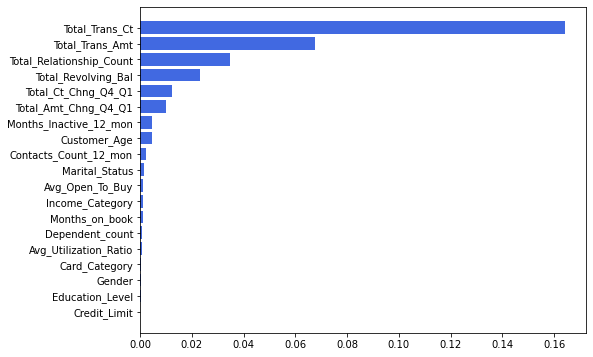

In [13]:
fig = plt.figure(figsize=(8,6))
plt.barh(PFI.index,PFI.values,color='royalblue')

----